## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
import skimage
from skimage import transform

In [3]:
import hw

## Load data

In [4]:
cropped_data_dir = 'data/CroppedYale/'
cropped = hw.LoadCropped(cropped_data_dir)

In [5]:
X             = cropped.X
y             = cropped.y
h             = cropped.h
w             = cropped.w
target_names  = cropped.target_names
n_samples     = cropped.n_samples
n_features    = cropped.n_features
n_classes     = cropped.n_classes

## Downsample images

In [6]:
ims = []
for i in cropped.X:
    ims.append(i.reshape(h,w))
images = np.array(ims)

ims = []
for i in images:
    im = skimage.transform.rescale(i, 0.2)
    ims.append(im)
ims = np.array(ims)

h = ims.shape[1]
w = ims.shape[2]

X = []
for i in ims:
    X.append(i.flatten())
X = np.array(X)

## Split into training and test data


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Gaussian Mixture Model classification with cross-validation

In [8]:
classes = 8

In [9]:
param_grid = {'tol': [0.001,0.1,1,10]}
model = GaussianMixture(n_components=classes)

In [29]:
%%time
clf = GridSearchCV(model, param_grid)
clf = clf.fit(X_train)

CPU times: user 22min 1s, sys: 2min, total: 24min 1s
Wall time: 4min 36s


In [11]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.1, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


In [28]:
clf.cv_results_

{'mean_fit_time': array([5.16639733, 5.37942128, 5.8017549 , 7.88878436]),
 'std_fit_time': array([0.08767771, 0.0619906 , 0.37411409, 0.9274868 ]),
 'mean_score_time': array([0.14744277, 0.14479523, 0.16188383, 0.22157063]),
 'std_score_time': array([0.01327301, 0.00339507, 0.01697153, 0.03532659]),
 'param_tol': masked_array(data=[0.001, 0.1, 1, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'tol': 0.001}, {'tol': 0.1}, {'tol': 1}, {'tol': 10}],
 'split0_test_score': array([-270207.56712829, -268507.98021659, -273492.42114111,
        -269656.87845963]),
 'split1_test_score': array([-245481.8086106 , -248242.241838  , -247714.95046998,
        -249131.33727882]),
 'split2_test_score': array([-271942.29561116, -258145.1160105 , -267627.54351451,
        -265481.55974707]),
 'split3_test_score': array([-252961.90926716, -232797.76238942, -243475.71214222,
        -252153.46608286]),
 'split4_test_score': array([-26

In [25]:
df = pd.DataFrame(clf.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time             5.37942
std_fit_time            0.0619906
mean_score_time          0.144795
std_score_time         0.00339507
param_tol                     0.1
params               {'tol': 0.1}
split0_test_score         -268508
split1_test_score         -248242
split2_test_score         -258145
split3_test_score         -232798
split4_test_score         -255301
mean_test_score           -252599
std_test_score              11851
rank_test_score                 1
Name: 1, dtype: object

In [46]:
model_labels = clf.best_estimator_.fit_predict(X_train)

In [47]:
class_count = []
average_class_images = []

for i in range(classes):
    im = X_train[(model_labels == i)]
    class_count.append(len(im))
    im = np.mean(im,axis=0)
    average_class_images.append(im)

average_class_images = np.vstack(average_class_images)

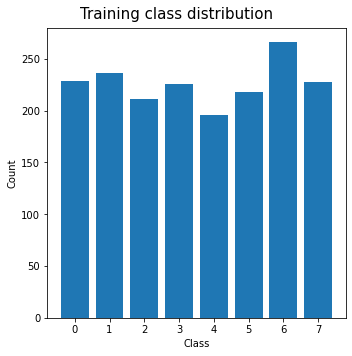

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(np.arange(classes), class_count)
ax.tick_params(axis='x')
ax.xaxis.set_ticks(np.arange(classes));

ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.suptitle('Training class distribution', fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('plots/unsupervised/gmm_bar_training.png');

In [51]:
labels = []
for i in np.arange(classes):
    i = 'Class: '+ str(i) + ' \n n: ' + str(class_count[i])
    labels.append(i)

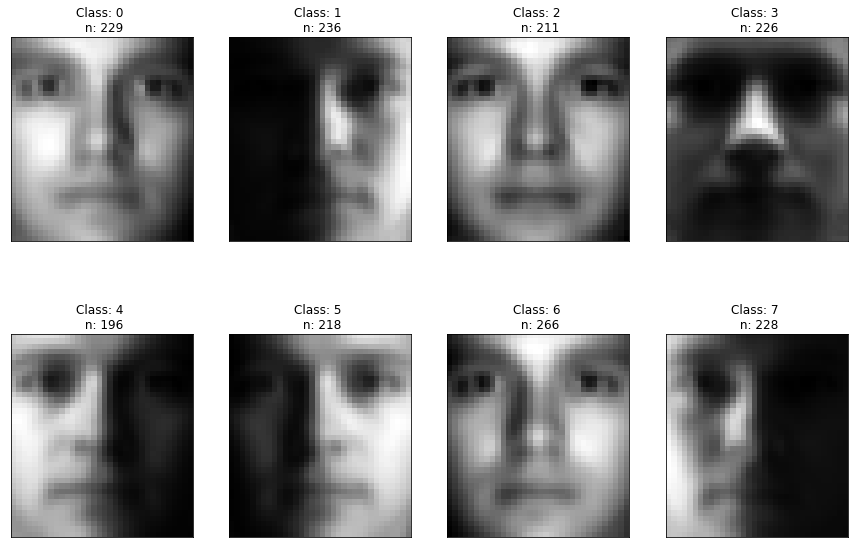

In [52]:
hw.plot_images_subset(average_class_images,
                       rows = 2,
                       columns = 4,
                       figsize= (15,10),reshape=(h,w),
                       labels = labels)
plt.savefig('plots/unsupervised/classes_training.png');

In [53]:
y_pred = clf.best_estimator_.predict(X_test)

In [54]:
class_count = []
average_class_images = []

for i in range(classes):
    im = X_test[(y_pred == i)]
    class_count.append(len(im))
    im = np.mean(im,axis=0)
    average_class_images.append(im)

average_class_images = np.vstack(average_class_images)

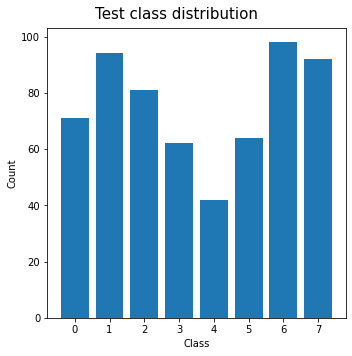

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(np.arange(classes), class_count)
ax.tick_params(axis='x')
ax.xaxis.set_ticks(np.arange(classes))

ax.set_xlabel('Class')
ax.set_ylabel('Count')
fig.suptitle('Test class distribution', fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('plots/unsupervised/gmm_bar_test.png');

In [56]:
labels = []
for i in np.arange(classes):
    i = 'Class: '+ str(i) + ' \n n: ' + str(class_count[i])
    labels.append(i)

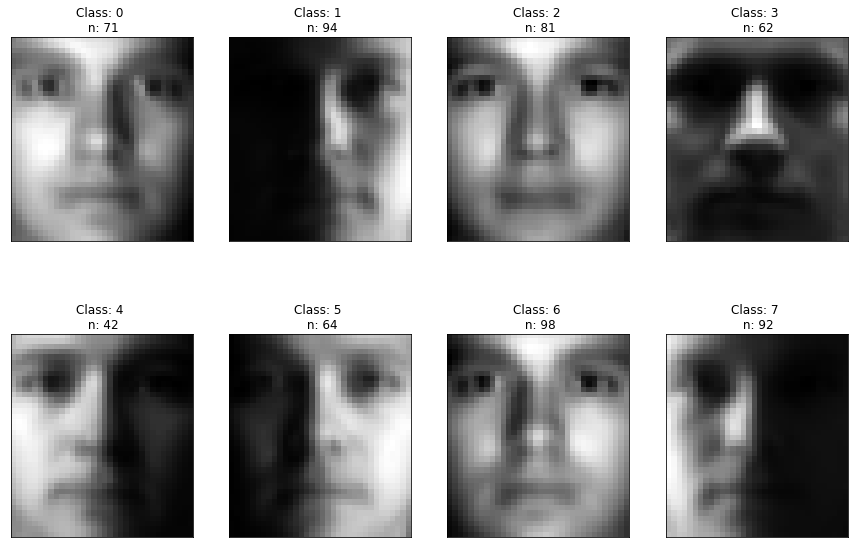

In [57]:
hw.plot_images_subset(average_class_images,
                       rows = 2,
                       columns = 4,
                       figsize= (15,10),reshape=(h,w),
                     labels = labels)
plt.savefig('plots/unsupervised/classes_test.png');